In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations, cramers_v, correlation_ratio, theils_u
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE
pd.set_option('display.max_columns', None)

import joblib

In [2]:
ori = pd.read_csv('bank-additional-full.csv', delimiter=';')
ori

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [3]:
df = ori.copy(deep=True)

In [4]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [5]:
df.pdays.unique()

array([999,   6,   4,   3,   5,   1,   0,  10,   7,   8,   9,  11,   2,
        12,  13,  14,  15,  16,  21,  17,  18,  22,  25,  26,  19,  27,
        20], dtype=int64)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [7]:
# Mengecek informasi statistik dari kolom yang berisi data numerik
df_num = df.drop(columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y'])
df_num.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [8]:
# Mengecek null, unique, dan unique sample
dataDesc = []

for i in df.columns:
    dataDesc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((((df[i].isna().sum()) / len(df)) * 100), 2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(1).values
    ])
    
pd.DataFrame(dataDesc, columns=[
    "Data Features",
    "Data Types",
    "Null",
    "Null Percentage",
    "Unique",
    "Unique Sample"
])

,Data Features,Data Types,Null,Null Percentage,Unique,Unique Sample
0,age,int64,0,0.0,78,[68]
1,job,object,0,0.0,12,[entrepreneur]
2,marital,object,0,0.0,4,[divorced]
3,education,object,0,0.0,8,[professional.course]
4,default,object,0,0.0,3,[yes]
5,housing,object,0,0.0,3,[yes]
6,loan,object,0,0.0,3,[unknown]
7,contact,object,0,0.0,2,[telephone]
8,month,object,0,0.0,10,[aug]
9,day_of_week,object,0,0.0,5,[tue]


In [9]:
# Mengecek outliers
Desc_outliers = []
hitung = 0

for i in df_num:
    Q1 = df.describe()[i]['25%']
    Q3 = df.describe()[i]['75%']
    IQR = Q3 - Q1
    upper_fence = Q3 + (1.5*IQR)
    lower_fence = Q1 - (1.5*IQR)
    hitung = 0
    temp = []
    for j in df[i]:
        if (j < lower_fence) | (j > upper_fence) :
            hitung+=1
            temp.append(j)
    Desc_outliers.append([
        i,
        hitung,
    ])

pd.DataFrame(Desc_outliers, columns=[
    "Data Features",
    "Jumlah Outliers"
])

,Data Features,Jumlah Outliers
0,age,469
1,duration,2963
2,campaign,2406
3,pdays,1515
4,previous,5625
5,emp.var.rate,0
6,cons.price.idx,0
7,cons.conf.idx,447
8,euribor3m,0
9,nr.employed,0


In [10]:
df['y'].value_counts()/len(df)*100

no     88.734583
yes    11.265417
Name: y, dtype: float64

In [11]:
df_num.corr()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


In [12]:
df_cat = df.drop(columns=df_num.columns)

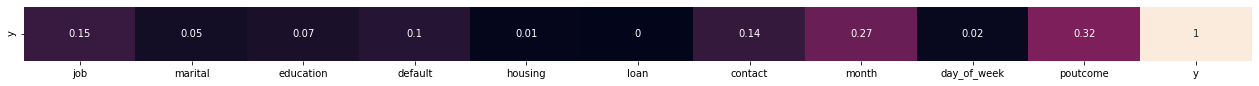

In [13]:
assoc_cramers = []
for i in df_cat.columns:
    assoc = round(cramers_v(df['y'], df_cat[i]), 2)
    assoc_cramers.append(assoc)

data_cramers = pd.DataFrame(data = [assoc_cramers], columns = df_cat.columns, index = ['y'])

plt.figure(figsize=(22, 1))
sns.heatmap(data_cramers, annot=True, cbar=False)
plt.show()

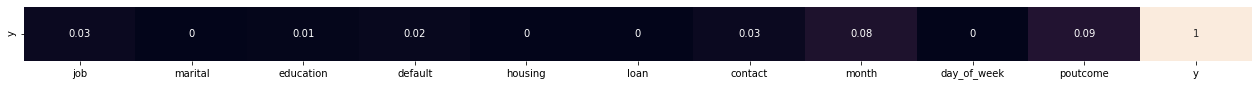

In [14]:
assoc_theils = []
for i in df_cat.columns:
    assoc = round(theils_u(df['y'], df_cat[i]), 2)
    assoc_theils.append(assoc)

data_theils = pd.DataFrame(data = [assoc_theils], columns = df_cat.columns, index = ['y'])

plt.figure(figsize=(22, 1))
sns.heatmap(data_theils, annot=True, cbar=False)
plt.show()

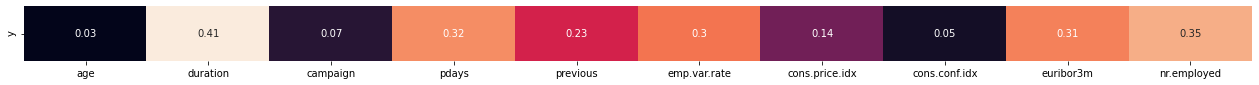

In [15]:
corr_rat = []
for i in df_num.columns:
    a = round(correlation_ratio(df['y'], df_num[i]), 2)
    corr_rat.append(a)

data_corr_rat = pd.DataFrame(data = [corr_rat], columns = df_num.columns, index = ['y'])

plt.figure(figsize=(22, 1))
sns.heatmap(data_corr_rat, annot=True, cbar=False)
plt.show()

In [16]:
df.education = df.education.apply(lambda x : x.replace(".", " "))
df_cat.education = df.education.apply(lambda x : x.replace(".", " "))

In [17]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic 4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic 6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


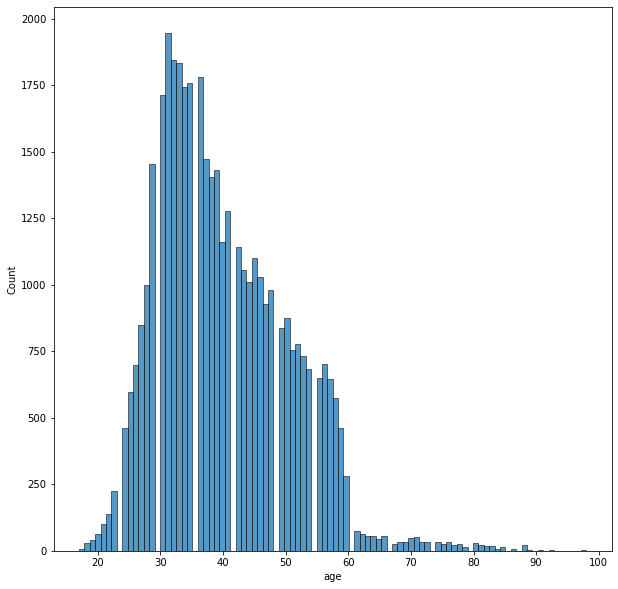

In [18]:
plt.figure(figsize=(10,10))
sns.histplot(x=df['age'])
plt.show()

In [19]:
# Pengelompokan kategori usia
age_bin = [0, 10, 20, 40, df['age'].max()] ## Membuat Kelompok Usia
labels = ['Kids', 'Teenager', 'Adult', 'Elder'] ## Label untuk Kelompok Usia
df['age_bin'] = pd.cut(df['age'], bins=age_bin, labels=labels)

In [20]:
age = pd.crosstab(index = df["age_bin"], columns = 'Jumlah')
age['Persentase'] = ''
persen = []
for a in age["Jumlah"]:
    persen.append(a/age['Jumlah'].sum()*100)
age['Persentase'] = persen
age

col_0,Jumlah,Persentase
age_bin,,
Teenager,140,0.339905
Adult,23628,57.366223
Elder,17420,42.293872


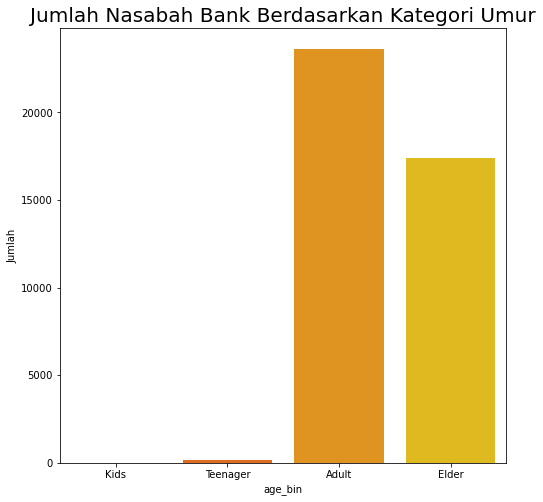

In [21]:
plt.figure(figsize=(8,8))
sns.barplot(data = age.reset_index(), x='age_bin', y='Jumlah', palette='autumn')
plt.title("Jumlah Nasabah Bank Berdasarkan Kategori Umur", size=20)
plt.show()

In [22]:
job = pd.crosstab(index = df["job"], columns = 'Jumlah')
job['Persentase'] = ''
persen = []
for a in job["Jumlah"]:
    persen.append(a/job['Jumlah'].sum()*100)
job['Persentase'] = persen
job

col_0,Jumlah,Persentase
job,,
admin.,10422,25.303486
blue-collar,9254,22.467709
entrepreneur,1456,3.535010
housemaid,1060,2.573565
management,2924,7.099155
retired,1720,4.175974
self-employed,1421,3.450034
services,3969,9.636302
student,875,2.124405


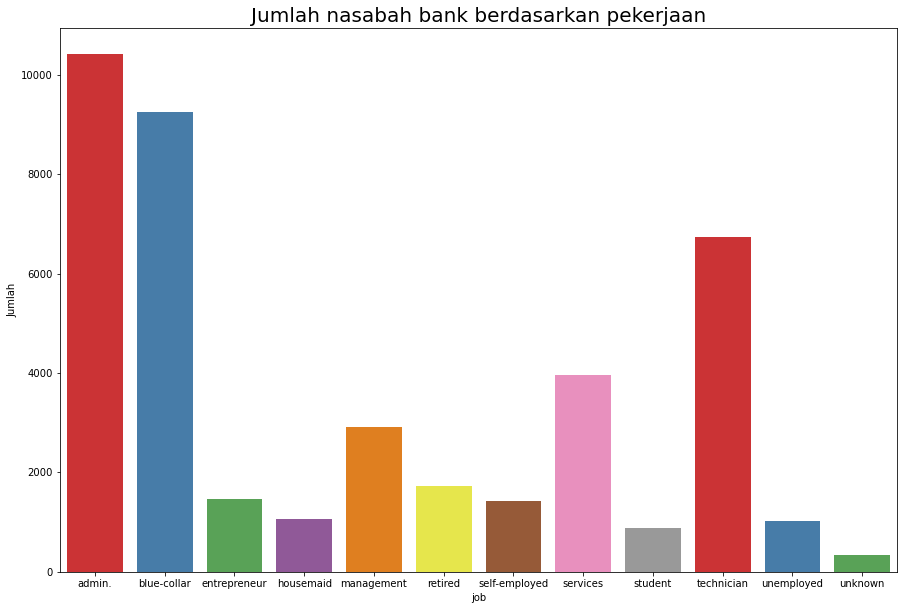

In [23]:
plt.figure(figsize=(15,10))
sns.barplot(data= job.reset_index(), x='job', y='Jumlah', palette='Set1')
plt.title("Jumlah nasabah bank berdasarkan pekerjaan", size=20)
plt.show()

In [24]:
mar = pd.crosstab(index = df["marital"], columns = 'Jumlah')
mar['Persentase'] = ''
persen = []
for a in mar["Jumlah"]:
    persen.append(a/mar['Jumlah'].sum()*100)
mar['Persentase'] = persen
mar

col_0,Jumlah,Persentase
marital,,
divorced,4612,11.197436
married,24928,60.522482
single,11568,28.085850
unknown,80,0.194231


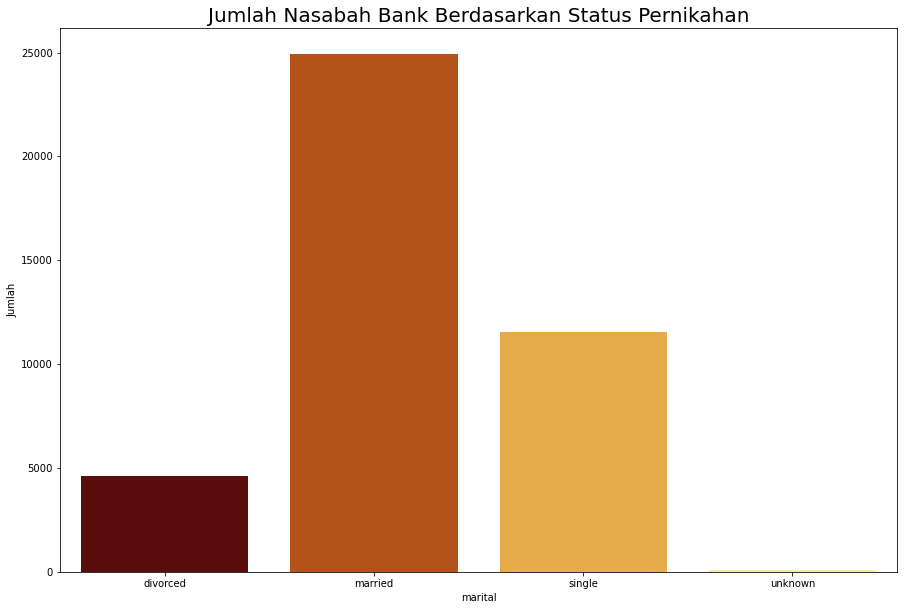

In [25]:
plt.figure(figsize=(15,10))
sns.barplot(data= mar.reset_index(), x='marital', y='Jumlah', palette='afmhot')
plt.title("Jumlah Nasabah Bank Berdasarkan Status Pernikahan", size=20)
plt.show()

In [26]:
edu = pd.crosstab(index = df["education"], columns = 'Jumlah')
edu['Persentase'] = ''
persen = []
for a in edu["Jumlah"]:
    persen.append(a/edu['Jumlah'].sum()*100)
edu['Persentase'] = persen
edu

col_0,Jumlah,Persentase
education,,
basic 4y,4176,10.138875
basic 6y,2292,5.564728
basic 9y,6045,14.676605
high school,9515,23.101389
illiterate,18,0.043702
professional course,5243,12.729436
university degree,12168,29.542585
unknown,1731,4.202680


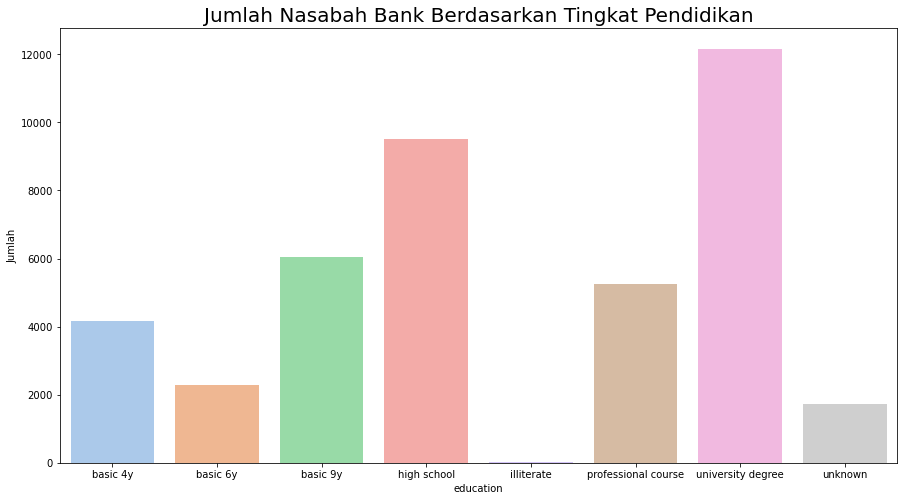

In [27]:
plt.figure(figsize=(15,8))
sns.barplot(data = edu.reset_index(), x='education', y='Jumlah', palette='pastel')
plt.title("Jumlah Nasabah Bank Berdasarkan Tingkat Pendidikan", size=20)
plt.show()

In [28]:
de = pd.crosstab(index = df["default"], columns = 'Jumlah')
de['Persentase'] = ''
persen = []
for a in de["Jumlah"]:
    persen.append(a/de['Jumlah'].sum()*100)
de['Persentase'] = persen
de

col_0,Jumlah,Persentase
default,,
no,32588,79.120132
unknown,8597,20.872584
yes,3,0.007284


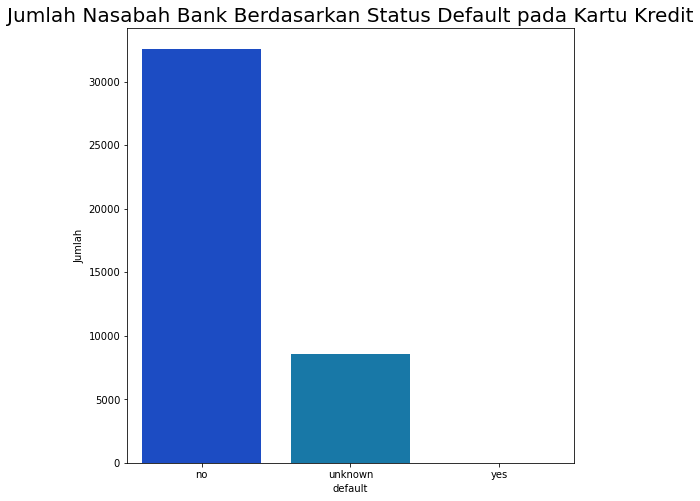

In [29]:
plt.figure(figsize=(8,8))
sns.barplot(data = de.reset_index(), x='default', y='Jumlah', palette='winter')
plt.title("Jumlah Nasabah Bank Berdasarkan Status Default pada Kartu Kredit", size=20)
plt.show()

In [30]:
house = pd.crosstab(index = df["housing"], columns = 'Jumlah')
house['Persentase'] = ''
persen = []
for a in house["Jumlah"]:
    persen.append(a/house['Jumlah'].sum()*100)
house['Persentase'] = persen
house

col_0,Jumlah,Persentase
housing,,
no,18622,45.212198
unknown,990,2.403613
yes,21576,52.384190


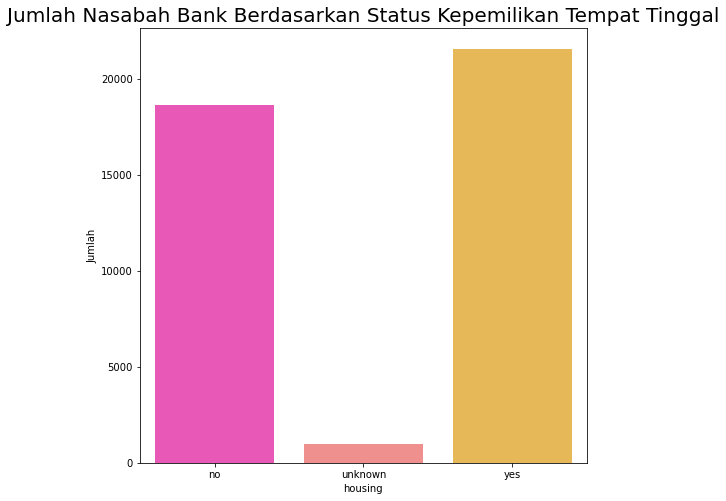

In [31]:
plt.figure(figsize=(8,8))
sns.barplot(data = house.reset_index(), x='housing', y='Jumlah', palette='spring')
plt.title("Jumlah Nasabah Bank Berdasarkan Status Kepemilikan Tempat Tinggal", size=20)
plt.show()

In [32]:
loan = pd.crosstab(index = df["loan"], columns = 'Jumlah')
loan['Persentase'] = ''
persen = []
for a in loan["Jumlah"]:
    persen.append(a/loan['Jumlah'].sum()*100)
loan['Persentase'] = persen
loan

col_0,Jumlah,Persentase
loan,,
no,33950,82.426920
unknown,990,2.403613
yes,6248,15.169467


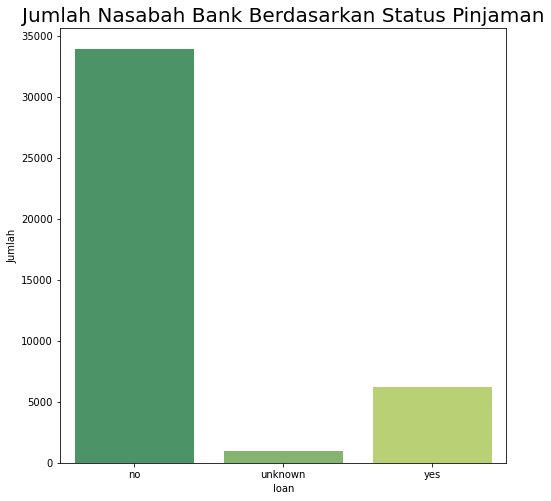

In [33]:
plt.figure(figsize=(8,8))
sns.barplot(data = loan.reset_index(), x='loan', y='Jumlah', palette='summer')
plt.title("Jumlah Nasabah Bank Berdasarkan Status Pinjaman", size=20)
plt.show()

In [34]:
con = pd.crosstab(index = df["contact"], columns = 'Jumlah')
con['Persentase'] = ''
persen = []
for a in con["Jumlah"]:
    persen.append(a/con['Jumlah'].sum()*100)
con['Persentase'] = persen
con

col_0,Jumlah,Persentase
contact,,
cellular,26144,63.474798
telephone,15044,36.525202


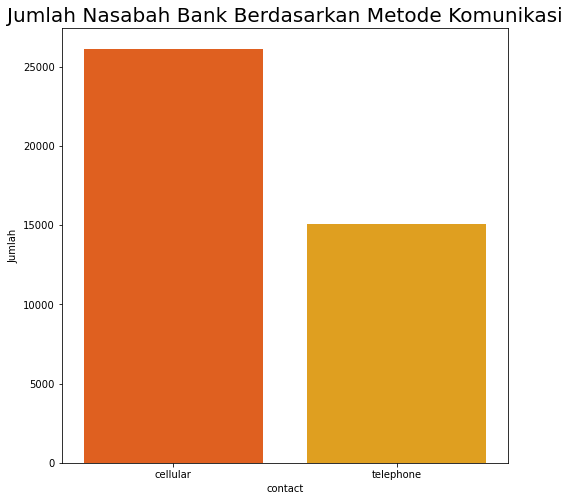

In [35]:
plt.figure(figsize=(8,8))
sns.barplot(data = con.reset_index(), x='contact', y='Jumlah', palette='autumn')
plt.title("Jumlah Nasabah Bank Berdasarkan Metode Komunikasi", size=20)
plt.show()

In [36]:
df['month'] = pd.Categorical(df['month'], ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])
mon = pd.crosstab(index = df["month"], columns = 'Jumlah')
mon['Persentase'] = ''
persen = []
for a in mon["Jumlah"]:
    persen.append(a/mon['Jumlah'].sum()*100)
mon['Persentase'] = persen
mon

col_0,Jumlah,Persentase
month,,
mar,546,1.325629
apr,2632,6.390211
may,13769,33.429640
jun,5318,12.911528
jul,7174,17.417694
aug,6178,14.999514
sep,570,1.383898
oct,718,1.743226
nov,4101,9.956784


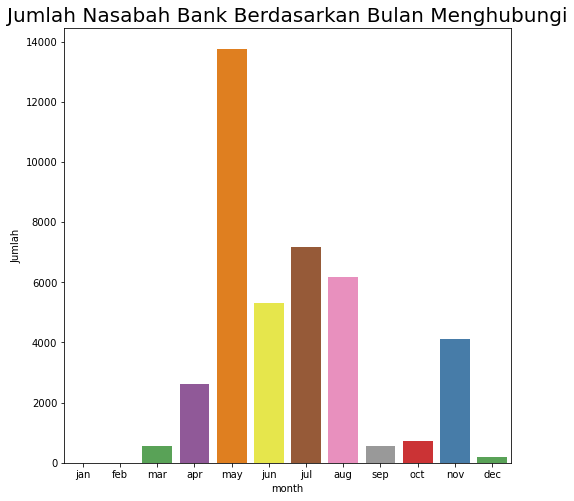

In [37]:
plt.figure(figsize=(8,8))
sns.barplot(data = mon.reset_index(), x='month', y='Jumlah', palette='Set1')
plt.title("Jumlah Nasabah Bank Berdasarkan Bulan Menghubungi", size=20)
plt.show()

In [38]:
df['day_of_week'] = pd.Categorical(df['day_of_week'], ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'])
day = pd.crosstab(index = df["day_of_week"], columns = 'Jumlah')
day['Persentase'] = ''
persen = []
for a in day["Jumlah"]:
    persen.append(a/day['Jumlah'].sum()*100)
day['Persentase'] = persen
day

col_0,Jumlah,Persentase
day_of_week,,
mon,8514,20.671069
tue,8090,19.641643
wed,8134,19.748470
thu,8623,20.935709
fri,7827,19.003108


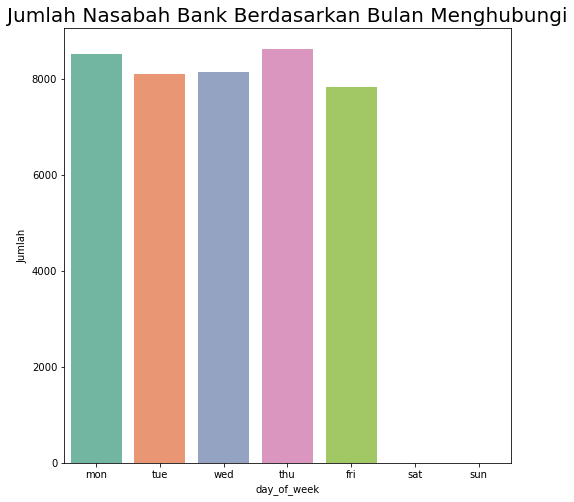

In [39]:
plt.figure(figsize=(8,8))
sns.barplot(data = day.reset_index(), x='day_of_week', y='Jumlah', palette='Set2')
plt.title("Jumlah Nasabah Bank Berdasarkan Bulan Menghubungi", size=20)
plt.show()

In [40]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'age_bin'],
      dtype='object')

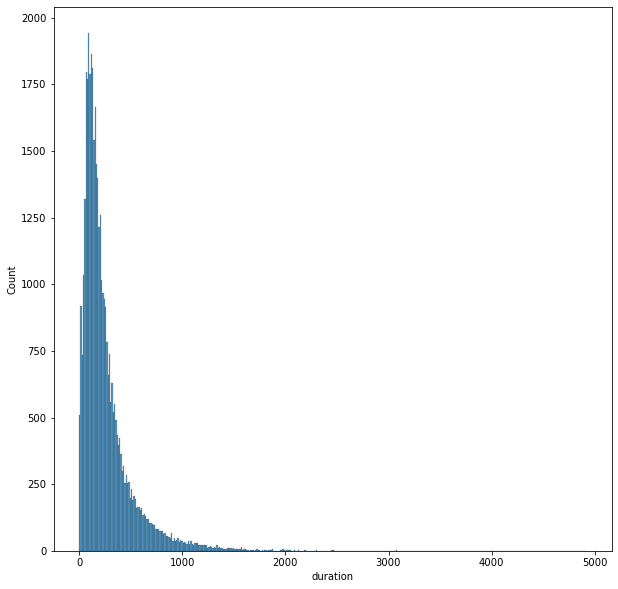

In [41]:
plt.figure(figsize=(10,10))
sns.histplot(x=df['duration'])
plt.show()

In [42]:
# Pengelompokan kategori durasi menelepon
dur_bin = [-1,180,360,540,720,900,1080,df['duration'].max()] ## Membuat Kelompok Durasi
labels_duration = ['0-3 menit', '3-6 menit', '6-9 menit', '9-12 menit', '12-15 menit', '15-18 menit', '>18 menit'] ## Label untuk Kelompok Durasi
df['dur_bin'] = pd.cut(df['duration'], bins=dur_bin, labels=labels_duration)

In [43]:
dur = pd.crosstab(index = df["dur_bin"], columns = 'Jumlah')
dur['Persentase'] = ''
persen = []
for a in dur["Jumlah"]:
    persen.append(a/dur['Jumlah'].sum()*100)
dur['Persentase'] = persen
dur

col_0,Jumlah,Persentase
dur_bin,,
0-3 menit,20705,50.269496
3-6 menit,11963,29.044867
6-9 menit,4246,10.308828
9-12 menit,1985,4.819365
12-15 menit,1008,2.447315
15-18 menit,527,1.279499
>18 menit,754,1.830630


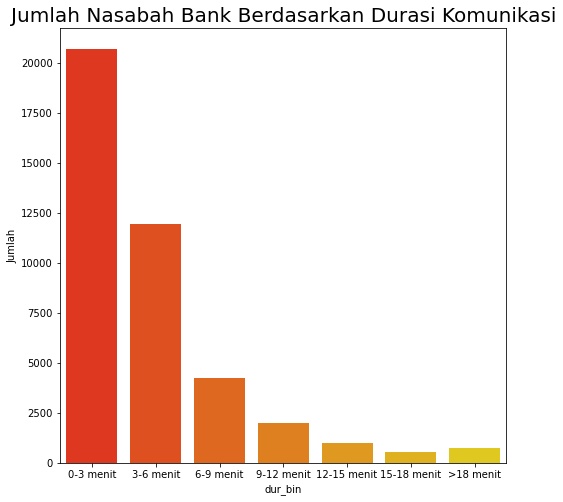

In [44]:
plt.figure(figsize=(8,8))
sns.barplot(data = dur.reset_index(), x='dur_bin', y='Jumlah', palette='autumn')
plt.title("Jumlah Nasabah Bank Berdasarkan Durasi Komunikasi", size=20)
plt.show()

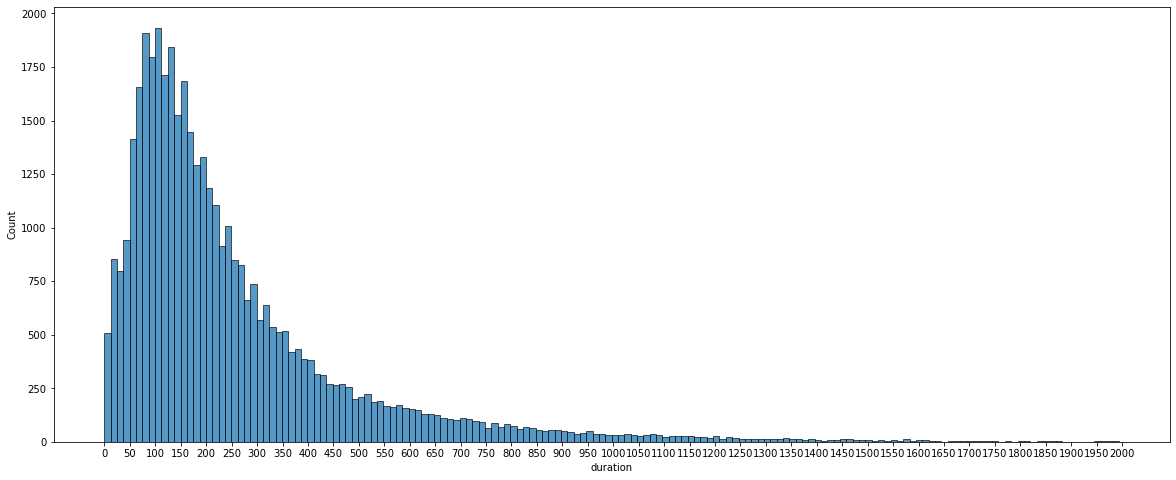

In [45]:
plt.figure(figsize=(20,8))
sns.histplot(x=df[df['duration'] <= 2000]['duration'])
plt.xticks(np.arange(0,2001,50))
plt.show()

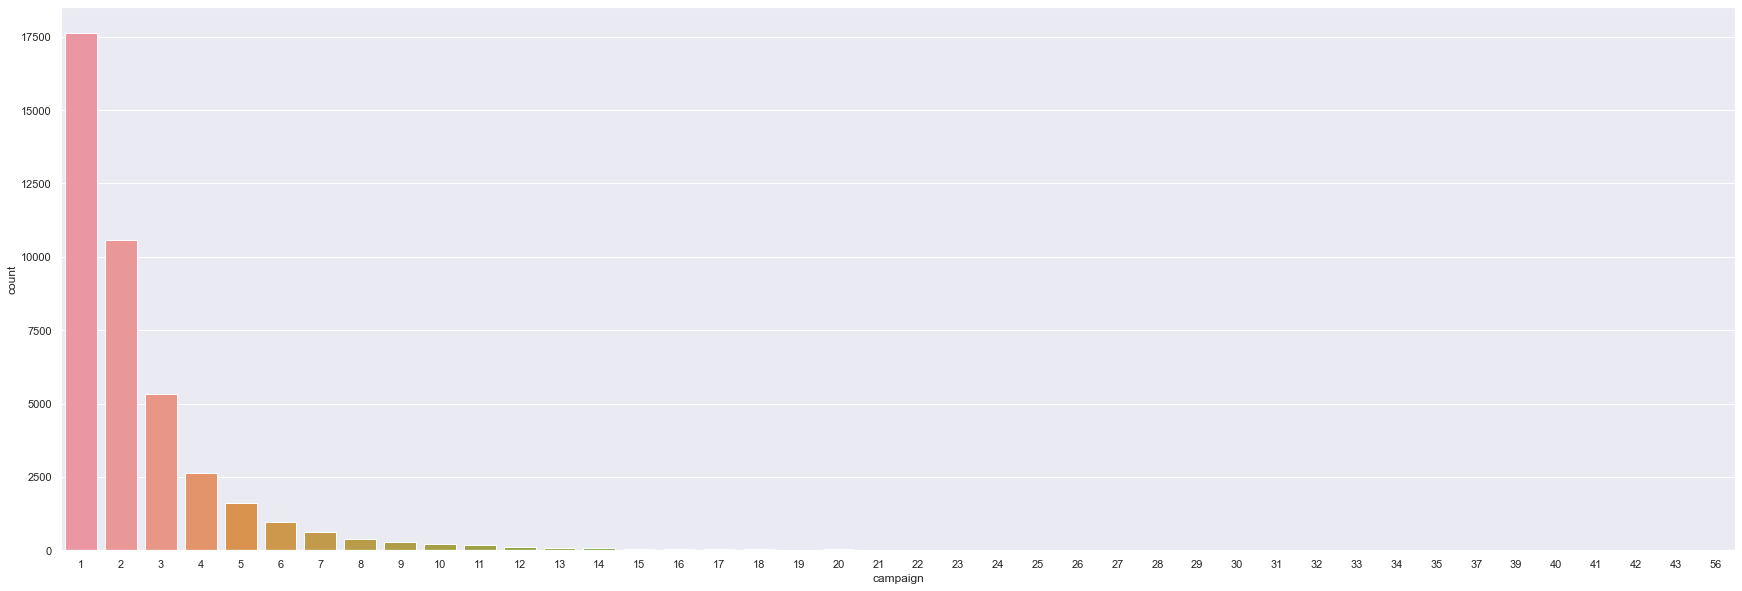

In [46]:
plt.figure(figsize=(30,10))
sns.set(rc={'figure.figsize':(20,10)})
sns.countplot(data=df, x='campaign')

plt.show()

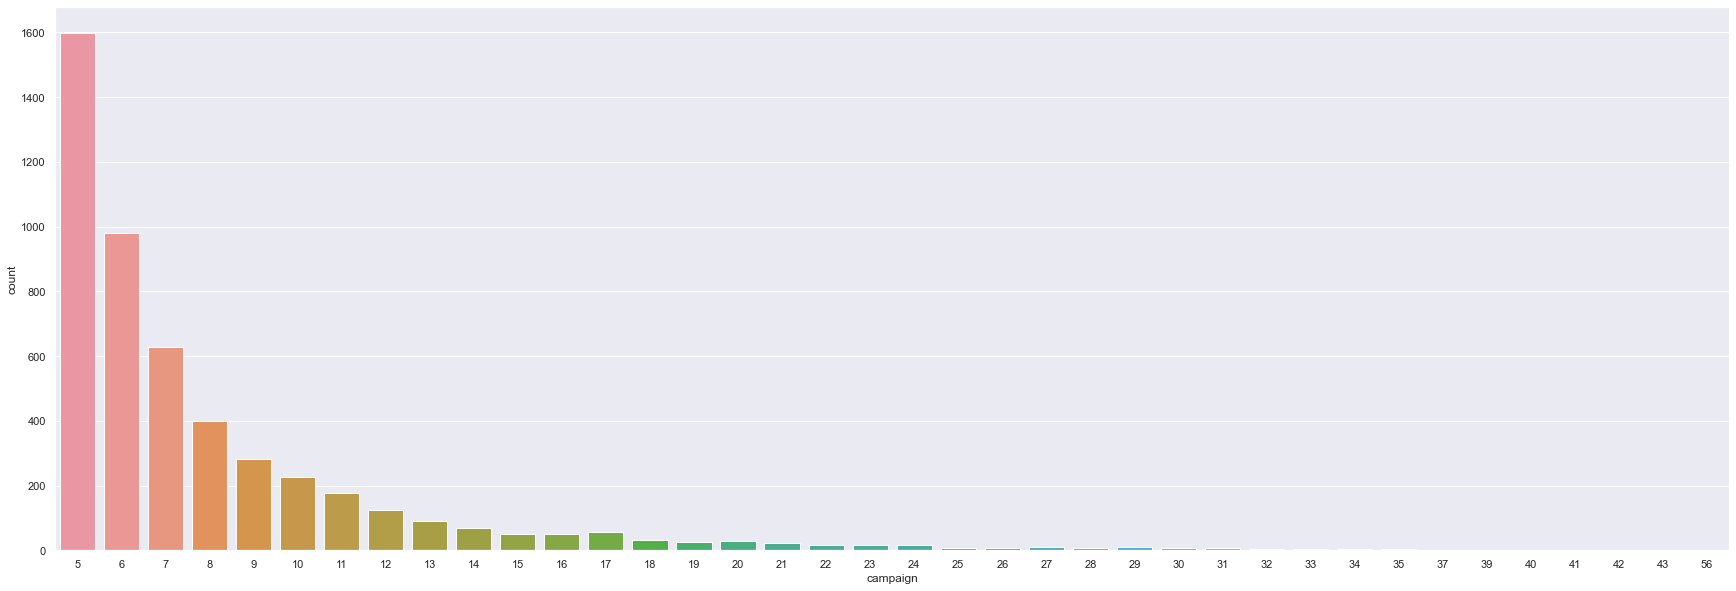

In [47]:
plt.figure(figsize=(30,10))
sns.set(rc={'figure.figsize':(20,10)})
sns.countplot(x=df[df['campaign']>4]['campaign'])

plt.show()

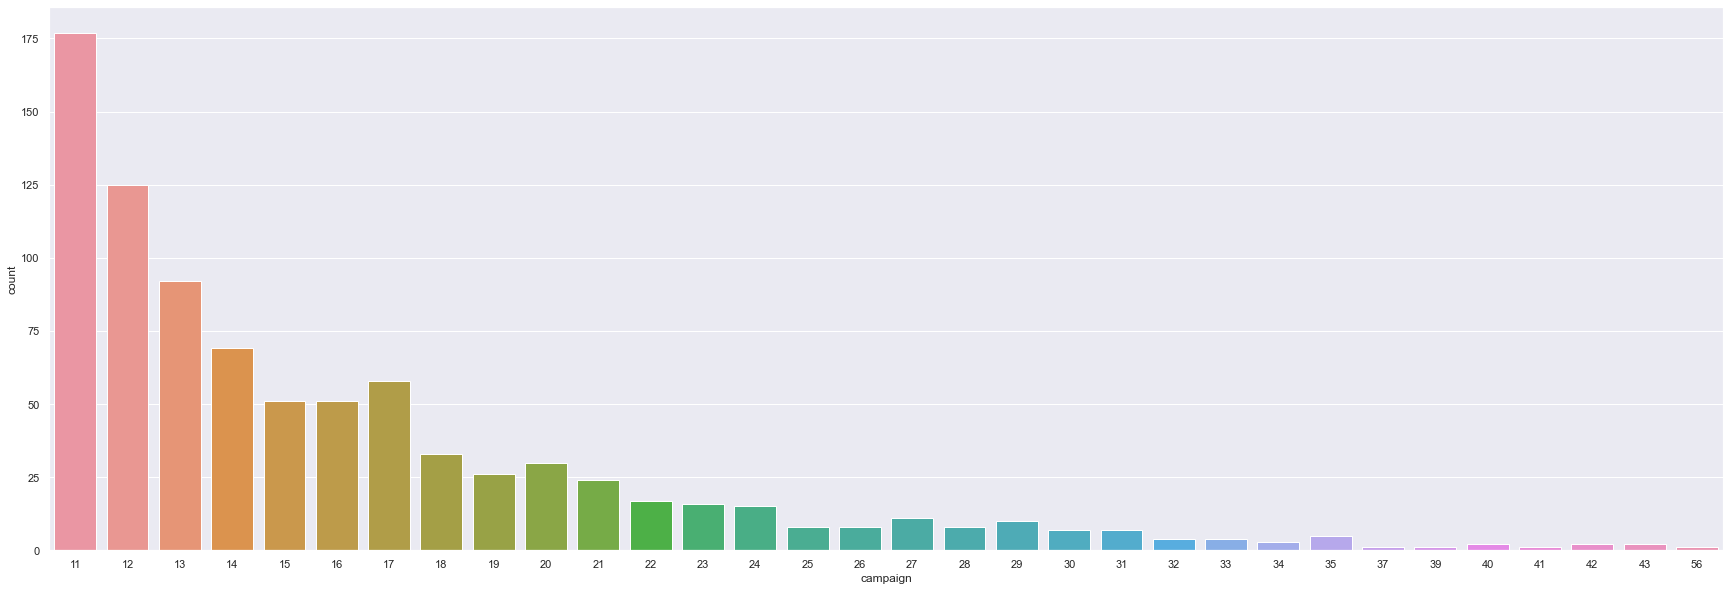

In [48]:
plt.figure(figsize=(30,10))
sns.set(rc={'figure.figsize':(20,10)})
sns.countplot(x=df[df['campaign']>10]['campaign'])

plt.show()

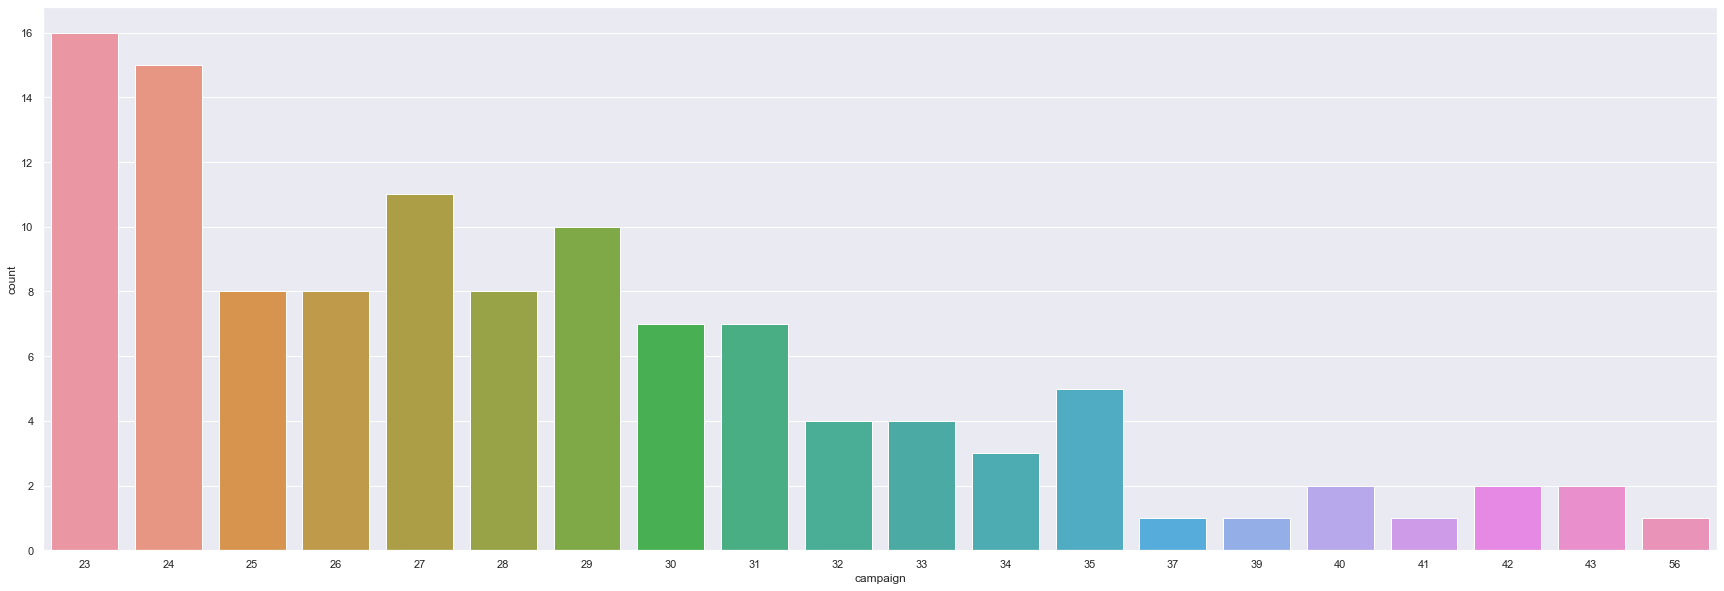

In [49]:
plt.figure(figsize=(30,10))
sns.set(rc={'figure.figsize':(20,10)})
sns.countplot(x=df[df['campaign']>22]['campaign'])

plt.show()

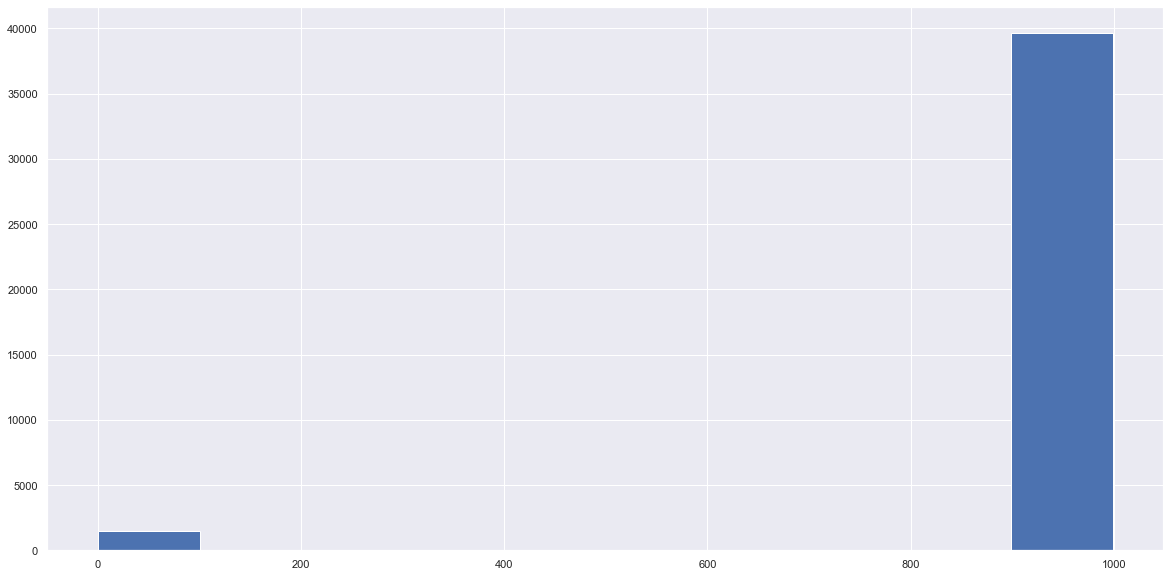

In [50]:
plt.figure(figsize=(20,10))
plt.hist(x=df['pdays'])
# sns.set(rc={'figure.figsize':(20,10)})
# sns.countplot(x=df[df['campaign']>22]['campaign'])

plt.show()

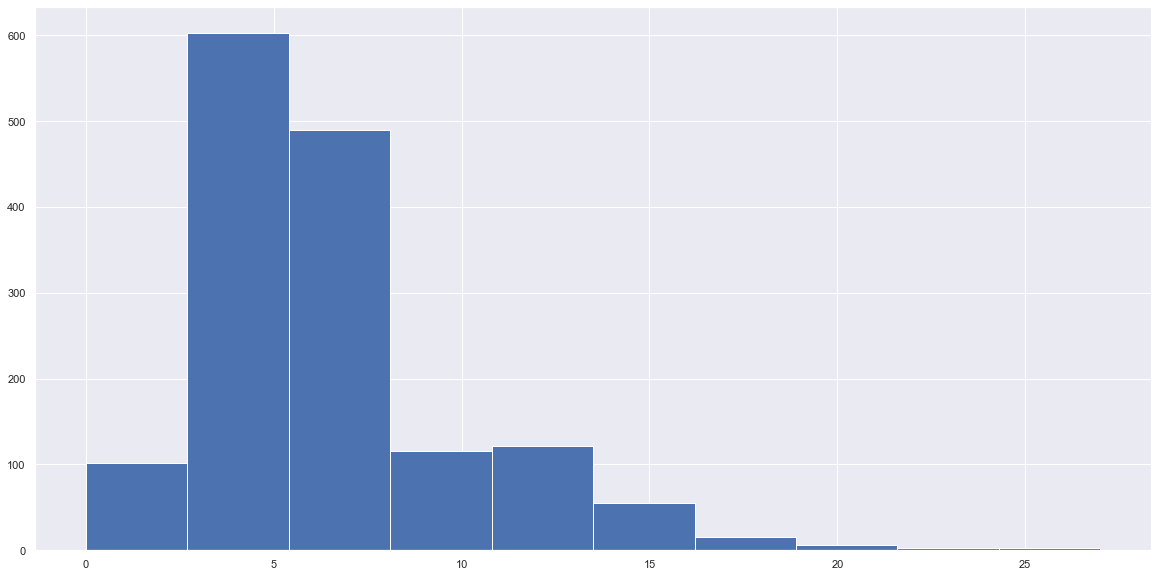

In [51]:
plt.figure(figsize=(20,10))
plt.hist(x=df[df['pdays']!=999]['pdays'])
# sns.set(rc={'figure.figsize':(20,10)})
# sns.countplot(x=df[df['campaign']>22]['campaign'])

plt.show()

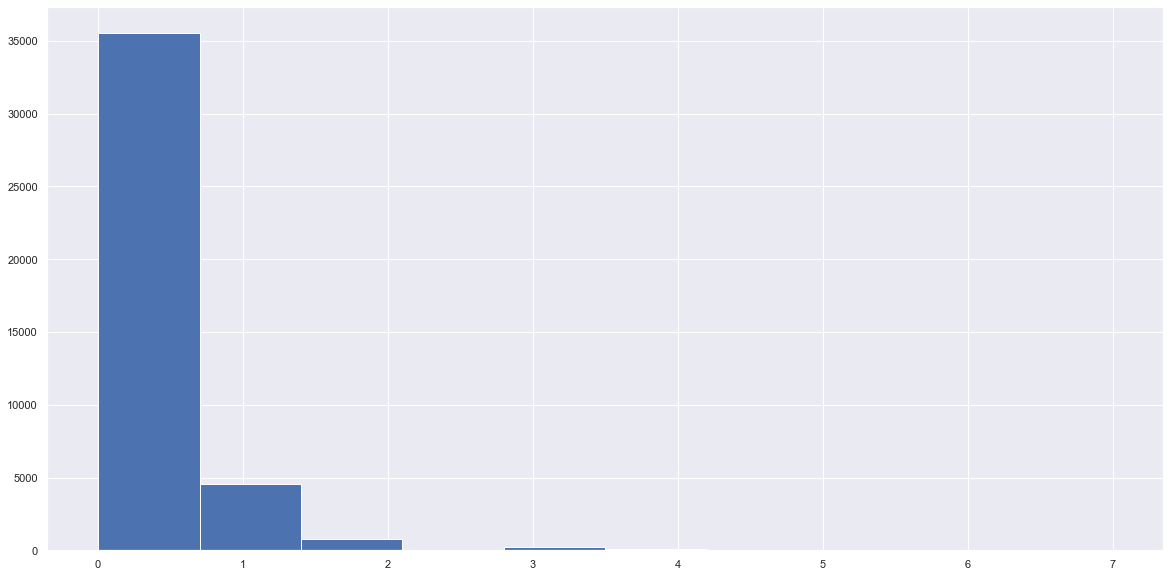

In [52]:
plt.figure(figsize=(20,10))
plt.hist(x=df['previous'])

plt.show()

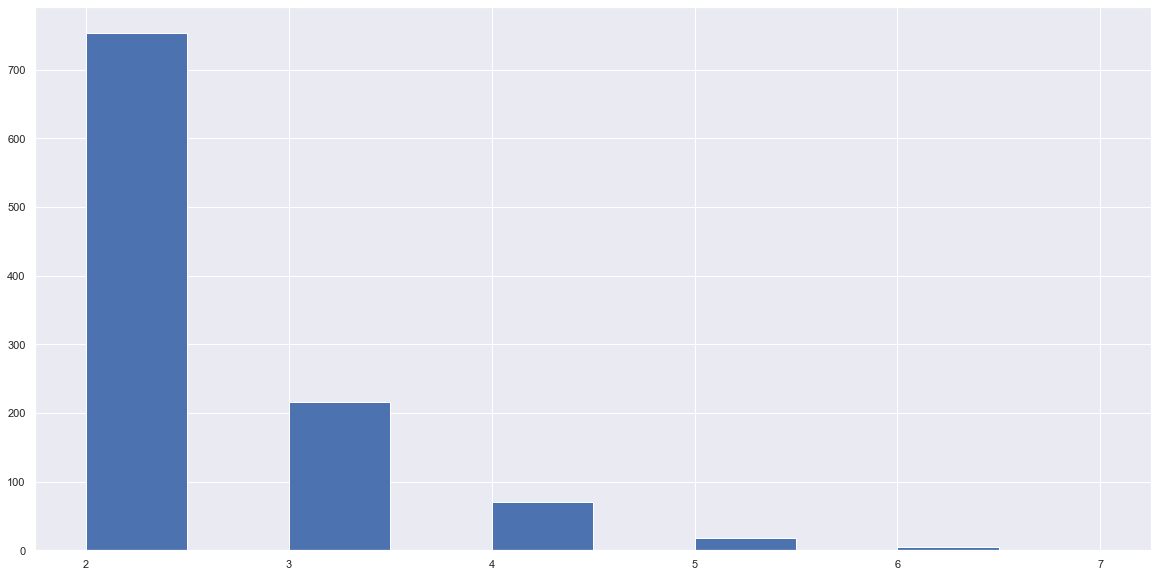

In [53]:
plt.figure(figsize=(20,10))
plt.hist(x=df[df['previous']>1]['previous'])

plt.show()

In [54]:
pout = pd.crosstab(index = df["poutcome"], columns = 'Jumlah')
pout['Persentase'] = ''
persen = []
for a in pout["Jumlah"]:
    persen.append(a/pout['Jumlah'].sum()*100)
pout['Persentase'] = persen
pout

col_0,Jumlah,Persentase
poutcome,,
failure,4252,10.323395
nonexistent,35563,86.343110
success,1373,3.333495


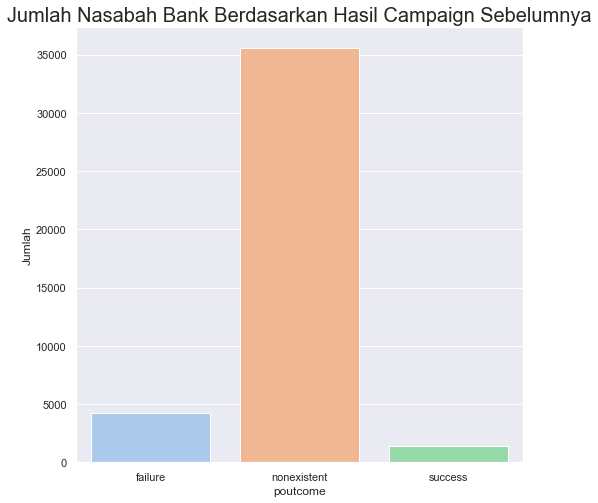

In [55]:
plt.figure(figsize=(8,8))
sns.barplot(data = pout.reset_index(), x='poutcome', y='Jumlah', palette='pastel')
plt.title("Jumlah Nasabah Bank Berdasarkan Hasil Campaign Sebelumnya", size=20)
plt.show()

In [56]:
df['emp.var.rate'].unique()

array([ 1.1,  1.4, -0.1, -0.2, -1.8, -2.9, -3.4, -3. , -1.7, -1.1])

In [57]:
emp = pd.crosstab(index = df["emp.var.rate"], columns = 'Jumlah')
emp['Persentase'] = ''
persen = []
for a in emp["Jumlah"]:
    persen.append(a/emp['Jumlah'].sum()*100)
emp['Persentase'] = persen
emp

col_0,Jumlah,Persentase
emp.var.rate,,
-3.4,1071,2.600272
-3.0,172,0.417597
-2.9,1663,4.037584
-1.8,9184,22.297757
-1.7,773,1.876760
-1.1,635,1.541711
-0.2,10,0.024279
-0.1,3683,8.941925
1.1,7763,18.847723


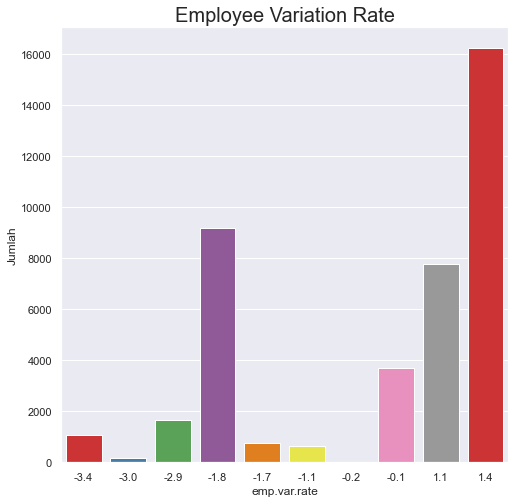

In [58]:
plt.figure(figsize=(8,8))
sns.barplot(data = emp.reset_index(), x='emp.var.rate', y='Jumlah', palette='Set1')
plt.title("Employee Variation Rate", size=20)
plt.show()

In [59]:
cons = pd.crosstab(index = df["cons.price.idx"], columns = 'Jumlah')
cons['Persentase'] = ''
persen = []
for a in cons["Jumlah"]:
    persen.append(a/cons['Jumlah'].sum()*100)
cons['Persentase'] = persen
cons

col_0,Jumlah,Persentase
cons.price.idx,,
92.201,770,1.869477
92.379,267,0.648247
92.431,447,1.085268
92.469,178,0.432165
92.649,357,0.866757
92.713,172,0.417597
92.756,10,0.024279
92.843,282,0.684665
92.893,5794,14.067204


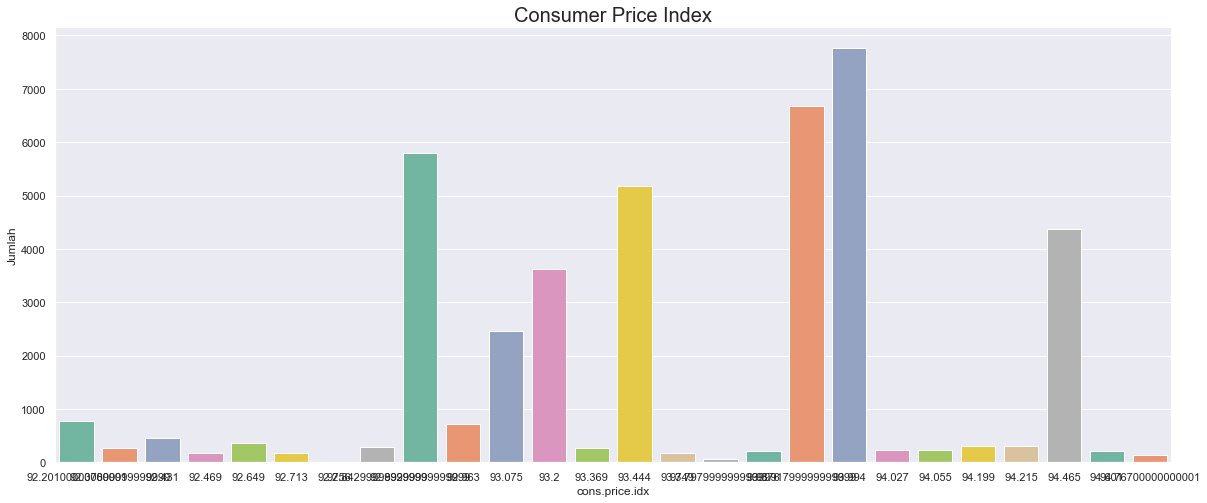

In [60]:
plt.figure(figsize=(20,8))
sns.barplot(data = cons.reset_index(), x='cons.price.idx', y='Jumlah', palette='Set2')
plt.title("Consumer Price Index", size=20)
plt.show()

In [61]:
conf = pd.crosstab(index = df["cons.conf.idx"], columns = 'Jumlah')
conf['Persentase'] = ''
persen = []
for a in conf["Jumlah"]:
    persen.append(a/conf['Jumlah'].sum()*100)
conf['Persentase'] = persen
conf

col_0,Jumlah,Persentase
cons.conf.idx,,
-50.8,128,0.310770
-50.0,282,0.684665
-49.5,204,0.495290
-47.1,2458,5.967758
-46.2,5794,14.067204
-45.9,10,0.024279
-42.7,6685,16.230455
-42.0,3616,8.779256
-41.8,4374,10.619598


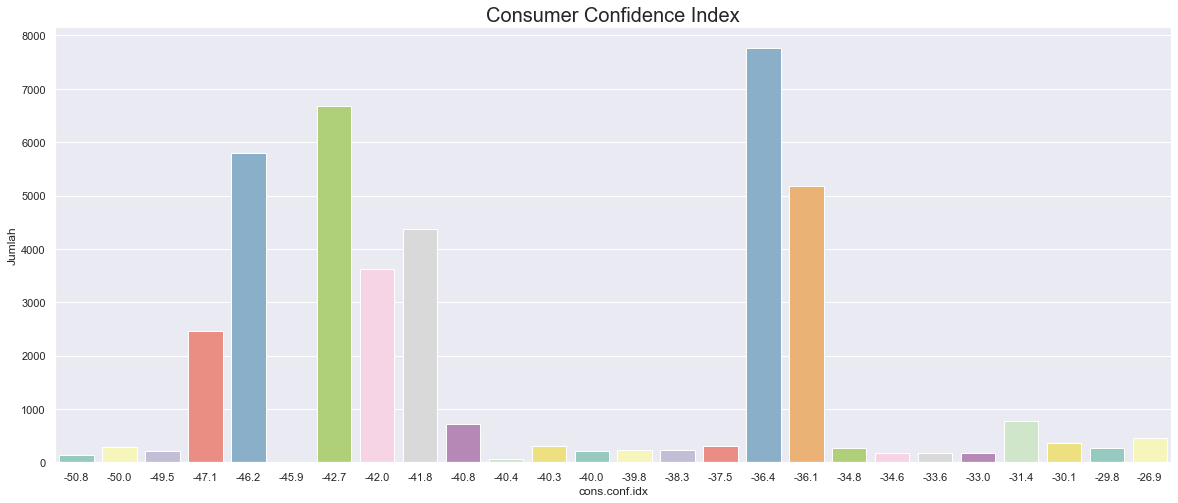

In [62]:
plt.figure(figsize=(20,8))
sns.barplot(data = conf.reset_index(), x='cons.conf.idx', y='Jumlah', palette='Set3')
plt.title("Consumer Confidence Index", size=20)
plt.show()

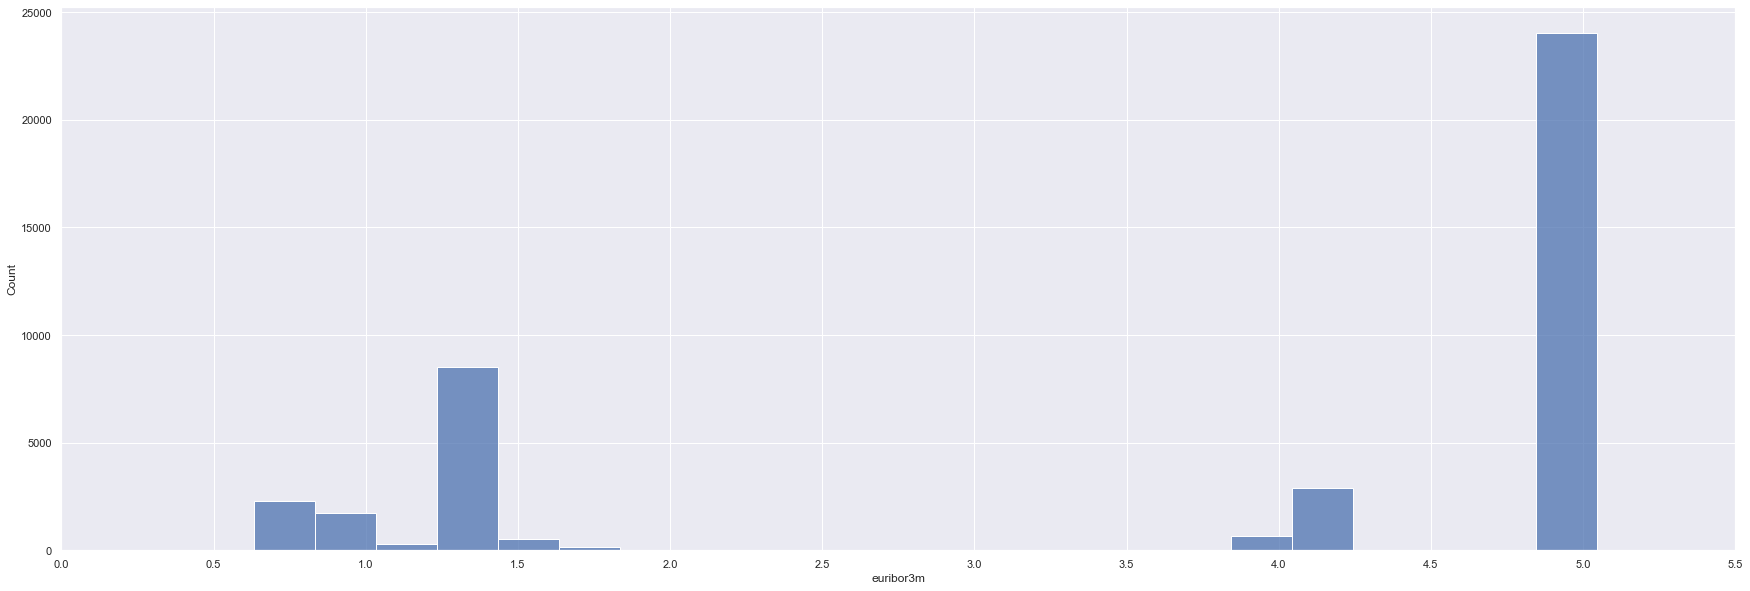

In [63]:
plt.figure(figsize=(30,10))
# sns.set(rc={'figure.figsize':(20,10)})
sns.histplot(data=df, x='euribor3m')
plt.xticks(np.arange(0,6,0.5))
plt.show()

In [64]:
nr = pd.crosstab(index = df["nr.employed"], columns = 'Jumlah')
nr['Persentase'] = ''
persen = []
for a in nr["Jumlah"]:
    persen.append(a/nr['Jumlah'].sum()*100)
nr['Persentase'] = persen
nr

col_0,Jumlah,Persentase
nr.employed,,
4963.6,635,1.541711
4991.6,773,1.876760
5008.7,650,1.578130
5017.5,1071,2.600272
5023.5,172,0.417597
5076.2,1663,4.037584
5099.1,8534,20.719627
5176.3,10,0.024279
5191.0,7763,18.847723


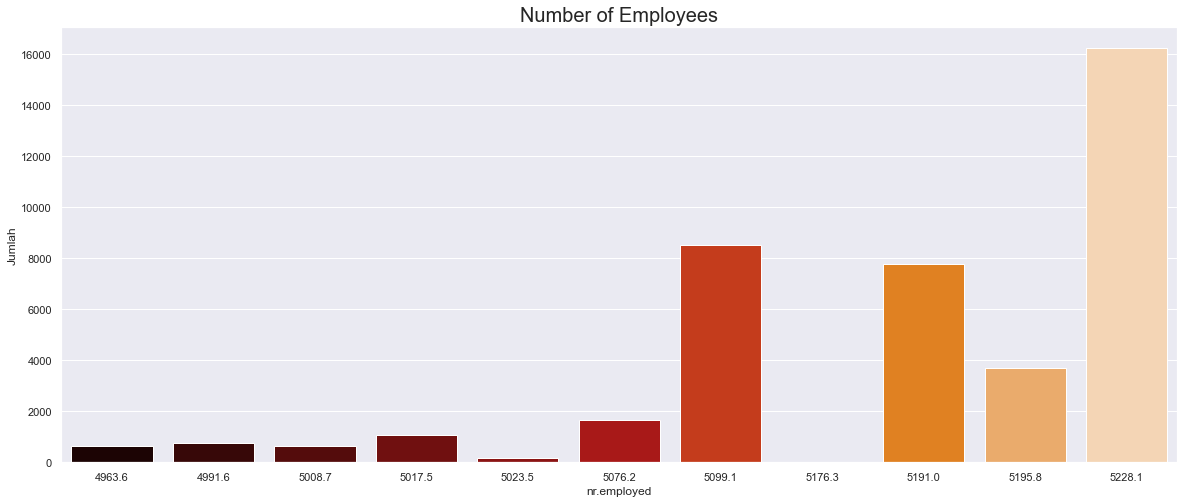

In [65]:
plt.figure(figsize=(20,8))
sns.barplot(data = nr.reset_index(), x='nr.employed', y='Jumlah', palette='gist_heat')
plt.title("Number of Employees", size=20)
plt.show()

In [66]:
res = pd.crosstab(index = df["y"], columns = 'Jumlah')
res['Persentase'] = ''
persen = []
for a in res["Jumlah"]:
    persen.append(a/res['Jumlah'].sum()*100)
res['Persentase'] = persen
res

col_0,Jumlah,Persentase
y,,
no,36548,88.734583
yes,4640,11.265417


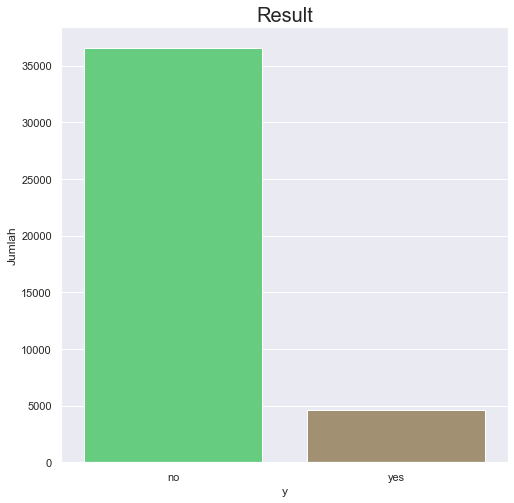

In [67]:
plt.figure(figsize=(8,8))
sns.barplot(data = res.reset_index(), x='y', y='Jumlah', palette='terrain')
plt.title("Result", size=20)
plt.show()

# Analisis Multivariate

### Analisis Multivariate terhadap Pembukaan Deposito

In [68]:
# Analisis Multivariate antara age dan y
(pd.crosstab(index = df['age_bin'], columns = df['y'], normalize = 'all')*100).round(2)

y,no,yes
age_bin,,
Teenager,0.20,0.14
Adult,50.90,6.47
Elder,37.63,4.66


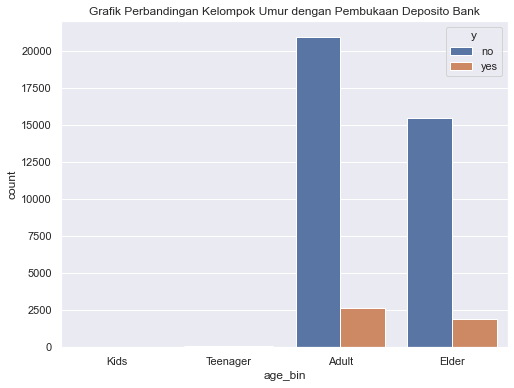

In [69]:
# Visualisasi data Analisis Multivariate antara age dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'age_bin', data = df , hue = 'y')
plt.title('Grafik Perbandingan Kelompok Umur dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Kelompok usia dewasa mendominasi pembukaan deposito di bank

In [70]:
# Analisis Multivariate antara job dan y
(pd.crosstab(index = df['job'], columns = df['y'], normalize = 'all')*100).round(2)

y,no,yes
job,,
admin.,22.02,3.28
blue-collar,20.92,1.55
entrepreneur,3.23,0.30
housemaid,2.32,0.26
management,6.30,0.80
retired,3.12,1.05
self-employed,3.09,0.36
services,8.85,0.78
student,1.46,0.67


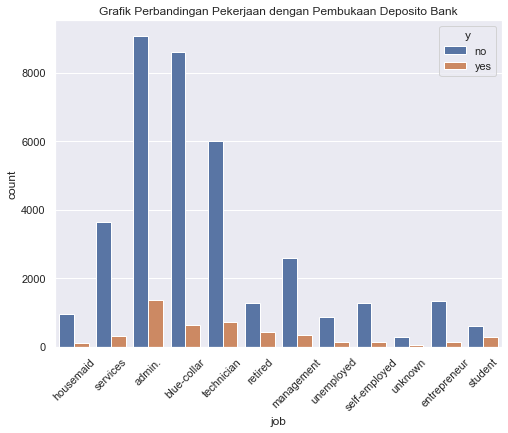

In [71]:
# Visualisasi data Analisis Multivariate antara job dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'job', data = df , hue = 'y')
plt.title('Grafik Perbandingan Pekerjaan dengan Pembukaan Deposito Bank')
plt.xticks(rotation=45)
plt.show()

Insight : Kelompok pekerja admin mendominasi pembuka deposito bank

In [72]:
# Analisis Multivariate antara marital dan y
(pd.crosstab(index = df['marital'], columns = df['y'], normalize = 'all')*100).round(2)

y,no,yes
marital,,
divorced,10.04,1.16
married,54.38,6.15
single,24.15,3.93
unknown,0.17,0.03


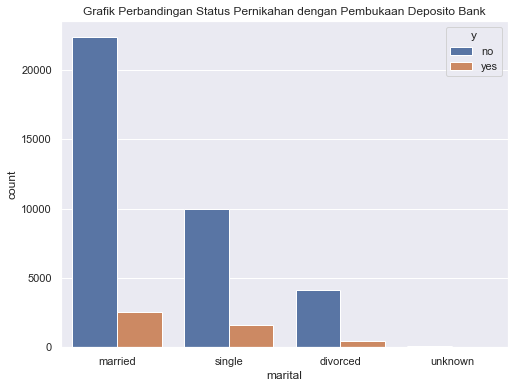

In [73]:
# Visualisasi data Analisis Multivariate antara marital dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'marital', data = df , hue = 'y')
plt.title('Grafik Perbandingan Status Pernikahan dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Kelompok nasabah dengan status pernikahan "sudah menikah" mendominasi pembukaan deposito

In [74]:
# Analisis Multivariate antara education dan y
(pd.crosstab(index = df['education'], columns = df['y'], normalize = 'all')*100).round(2)

y,no,yes
education,,
basic 4y,9.10,1.04
basic 6y,5.11,0.46
basic 9y,13.53,1.15
high school,20.60,2.50
illiterate,0.03,0.01
professional course,11.28,1.44
university degree,25.49,4.05
unknown,3.59,0.61


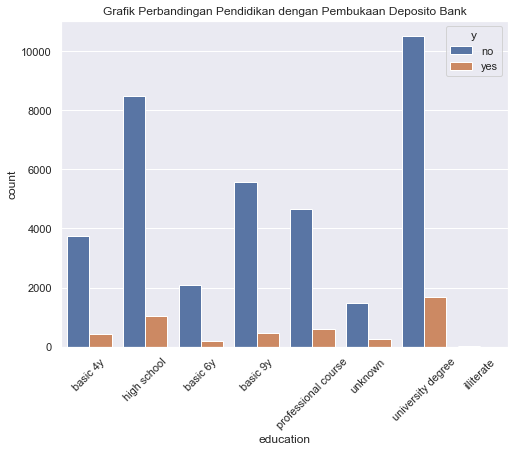

In [75]:
# Visualisasi data Analisis Multivariate antara education dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'education', data = df , hue = 'y')
plt.title('Grafik Perbandingan Pendidikan dengan Pembukaan Deposito Bank')
plt.xticks(rotation=45)
plt.show()

Insight : Kelompok nasabah dengan pendidikan terakhir sarjana mendominasi pembukaan deposito di bank

In [76]:
# Analisis Multivariate antara default dan y
(pd.crosstab(index = df['default'], columns = df['y'], normalize = 'all')*100).round(2)

y,no,yes
default,,
no,68.93,10.19
unknown,19.80,1.08
yes,0.01,0.00


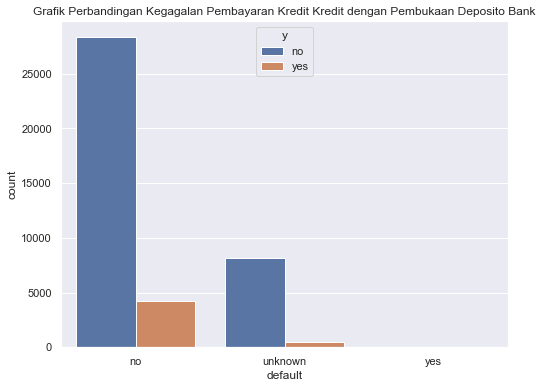

In [77]:
# Visualisasi data Analisis Multivariate antara default dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'default', data = df , hue = 'y')
plt.title('Grafik Perbandingan Kegagalan Pembayaran Kredit Kredit dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Kelompok nasabah yang tidak memiliki kredit atau pinjaman bank mendominasi pembukaan deposito di bank

In [78]:
# Analisis Multivariate antara housing dan y
(pd.crosstab(index = df['housing'], columns = df['y'], normalize = 'all')*100).round(2)

y,no,yes
housing,,
no,40.29,4.92
unknown,2.14,0.26
yes,46.30,6.09


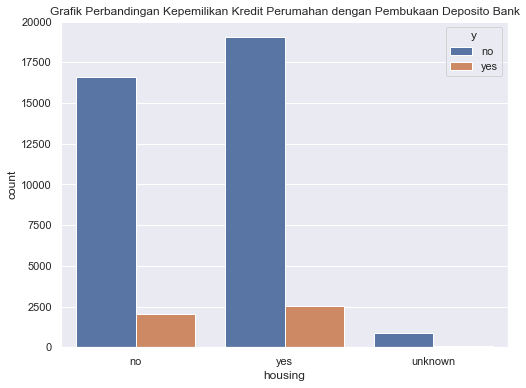

In [79]:
# Visualisasi data Analisis Multivariate antara housing dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'housing', data = df , hue = 'y')
plt.title('Grafik Perbandingan Kepemilikan Kredit Perumahan dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Kelompok nasabah dengan kepemilikan peminjaman perumahan mendominasi pembukaan deposito

In [80]:
# Analisis Multivariate antara loan dan y
(pd.crosstab(index = df['loan'], columns = df['y'], normalize = 'all')*100).round(2)

y,no,yes
loan,,
no,73.08,9.35
unknown,2.14,0.26
yes,13.51,1.66


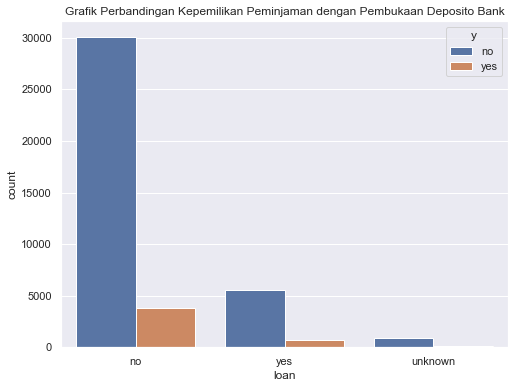

In [81]:
# Visualisasi data Analisis Multivariate antara loan dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'loan', data = df , hue = 'y')
plt.title('Grafik Perbandingan Kepemilikan Peminjaman dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Kelompok nasabah yang tidak memiliki peminjaman di bank mendominasi pembukaan deposito

In [82]:
# Analisis Multivariate antara contact dan y
(pd.crosstab(index = df['contact'], columns = df['y'], normalize = 'all')*100).round(2)

y,no,yes
contact,,
cellular,54.12,9.35
telephone,34.61,1.91


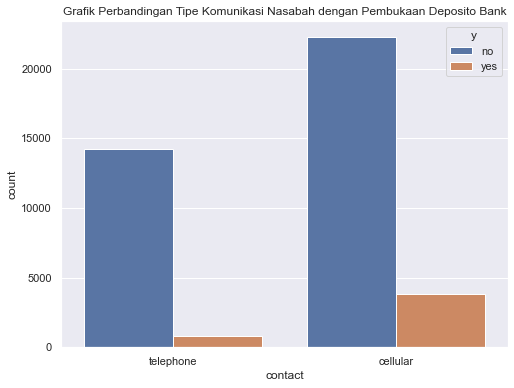

In [83]:
# Visualisasi data Analisis Multivariate antara contact dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'contact', data = df , hue = 'y')
plt.title('Grafik Perbandingan Tipe Komunikasi Nasabah dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Kelompok nasabah dengan jalur komunikasi melalui selular (telepon genggam) mendominasi nasabah yang melakukan pembukaan deposito

In [84]:
# Analisis Multivariate antara month dan y
(pd.crosstab(index = df['month'], columns = df['y'], normalize = 'all')*100).round(2)

y,no,yes
month,,
mar,0.66,0.67
apr,5.08,1.31
may,31.28,2.15
jun,11.55,1.36
jul,15.84,1.58
aug,13.41,1.59
sep,0.76,0.62
oct,0.98,0.76
nov,8.95,1.01


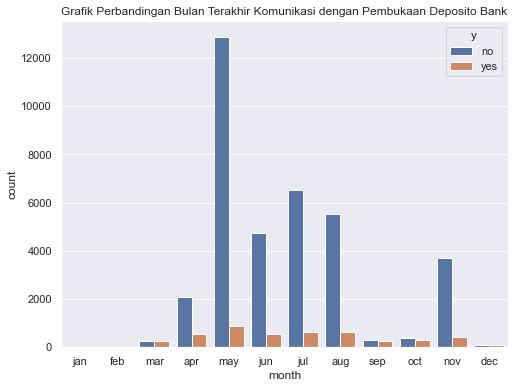

In [85]:
# Visualisasi data Analisis Multivariate antara month dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'month', data = df , hue = 'y')
plt.title('Grafik Perbandingan Bulan Terakhir Komunikasi dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Bulan terakhir komunikasi nasabah dengan tim kampanye didominasi di bulan Mei

In [86]:
# Analisis Multivariate antara day_of_week dan y
(pd.crosstab(index = df['day_of_week'], columns = df['y'], normalize = 'all')*100).round(2)

y,no,yes
day_of_week,,
mon,18.61,2.06
tue,17.33,2.31
wed,17.44,2.30
thu,18.40,2.54
fri,16.95,2.05


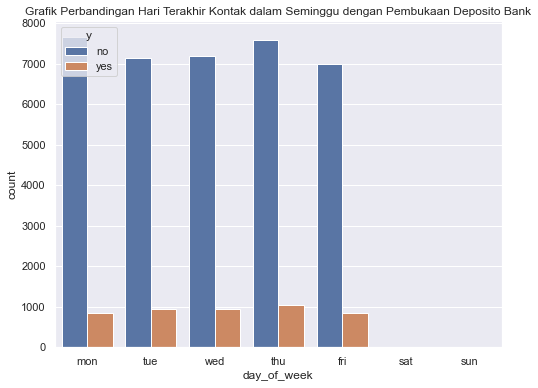

In [87]:
# Visualisasi data Analisis Multivariate antara day_of_week dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'day_of_week', data = df , hue = 'y')
plt.title('Grafik Perbandingan Hari Terakhir Kontak dalam Seminggu dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Hari terakhir komunikasi tim kampanye deposito dalam seminggu dengan nasabah didominasi oleh hari Kamis

In [88]:
# Analisis Multivariate antara duration dan y
(pd.crosstab(index = df['dur_bin'], columns = df['y'], normalize = 'all')*100).round(2)

y,no,yes
dur_bin,,
0-3 menit,48.90,1.37
3-6 menit,25.84,3.20
6-9 menit,8.30,2.01
9-12 menit,3.11,1.71
12-15 menit,1.31,1.14
15-18 menit,0.51,0.77
>18 menit,0.75,1.08


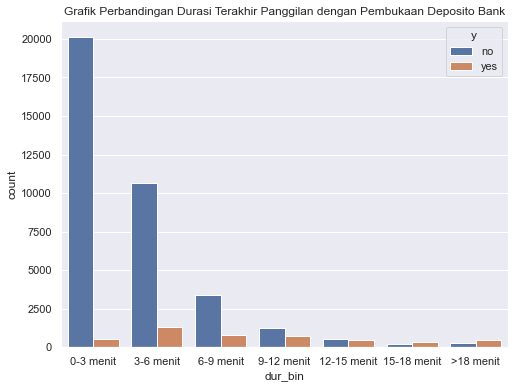

In [89]:
# Visualisasi data Analisis Multivariate antara duration dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'dur_bin', data = df , hue = 'y')
plt.title('Grafik Perbandingan Durasi Terakhir Panggilan dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Durasi terakhir panggilan antara nasabah bank dengan tim kampanye didominasi rentang 0 - 10 menit

In [90]:
# Pengelompokan kategori banyak kontak selama kampanye
cam_bin = [0, 10, 20, 30, 40, 50, df['campaign'].max()] ## Membuat Kelompok Campaign
labels_campaign = ['0 - 10 times', '10 - 20 times', '20 - 30 times', '30 - 40 times', '40-50 times', 'more than 50 times'] ## Label untuk Kelompok Campaign
df['cam_bin'] = pd.cut(df['campaign'], bins=cam_bin, labels=labels_campaign)

In [91]:
# Analisis Multivariate antara campaign dan y
(pd.crosstab(index = df['cam_bin'], columns = df['y'], normalize = 'all')*100).round(2)

y,no,yes
cam_bin,,
0 - 10 times,86.69,11.20
10 - 20 times,1.67,0.06
20 - 30 times,0.30,0.00
30 - 40 times,0.07,0.00
40-50 times,0.01,0.00
more than 50 times,0.00,0.00


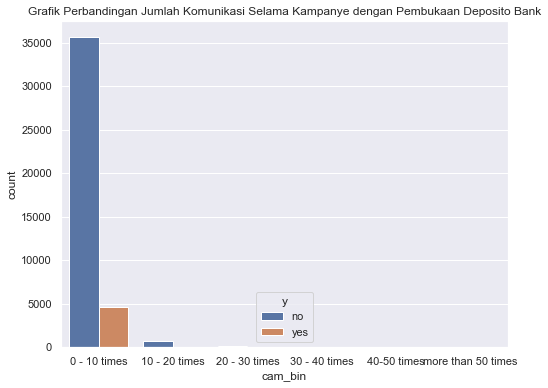

In [92]:
# Visualisasi data Analisis Multivariate antara campaign dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'cam_bin', data = df , hue = 'y')
plt.title('Grafik Perbandingan Jumlah Komunikasi Selama Kampanye dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Jumlah komunikasi tim kampanye dengan nasabah selama masa kampanye didominasi kelompok 0 - 10 kali

In [93]:
# Pengelompokan kategori banyak jumlah hari berlalu setelah kontak dengan nasabah selama kampanye
pdays_bin = [0, 10, 20, 30, df['pdays'].max()] ## Membuat Kelompok Pdays
labels_pdays = ['0 - 10 days', '10 - 20 days', '20 - 30 days', 'no contact'] ## Label untuk Kelompok Pdays
df['pdays_bin'] = pd.cut(df['pdays'], bins=pdays_bin, labels=labels_pdays)

In [94]:
# Analisis Multivariate antara pdays dan y
(pd.crosstab(index = df['pdays_bin'], columns = df['y'], normalize = 'all')*100).round(2)

y,no,yes
pdays_bin,,
0 - 10 days,1.11,2.04
10 - 20 days,0.21,0.26
20 - 30 days,0.00,0.02
no contact,87.44,8.92


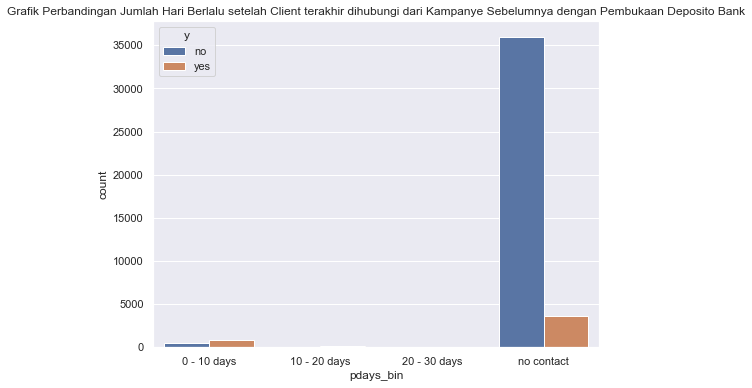

In [95]:
# Visualisasi data Analisis Multivariate antara pdays dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'pdays_bin', data = df , hue = 'y')
plt.title('Grafik Perbandingan Jumlah Hari Berlalu setelah Client terakhir dihubungi dari Kampanye Sebelumnya dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Client yang memilih untuk membuka deposito didominasi oleh client yang tidak dihubungi dari kampanye sebelumnya

In [96]:
# Analisis Multivariate antara previous dan y
(pd.crosstab(index = df['previous'], columns = df['y'], normalize = 'all')*100).round(2)

y,no,yes
previous,,
0,78.72,7.63
1,8.73,2.35
2,0.98,0.85
3,0.21,0.31
4,0.08,0.09
5,0.01,0.03
6,0.00,0.01
7,0.00,0.00


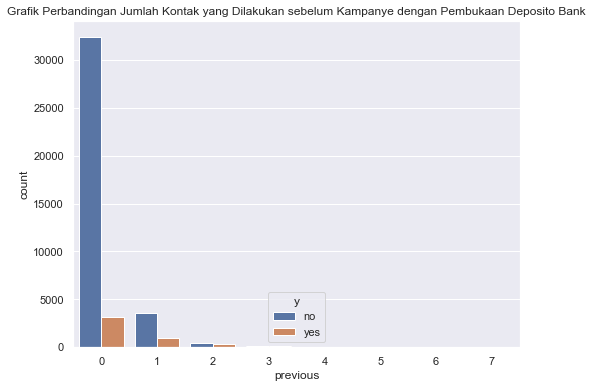

In [97]:
# Visualisasi data Analisis Multivariate antara previous dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'previous', data = df , hue = 'y')
plt.title('Grafik Perbandingan Jumlah Kontak yang Dilakukan sebelum Kampanye dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Client yang memilih untuk membuka deposito didominasi oleh kelompok yang tidak dihubungi oleh tim kampanye sebelum kampanye

In [98]:
# Analisis Multivariate antara poutcome dan y
(pd.crosstab(index = df['poutcome'], columns = df['y'], normalize = 'all')*100).round(2)

y,no,yes
poutcome,,
failure,8.85,1.47
nonexistent,78.72,7.63
success,1.16,2.17


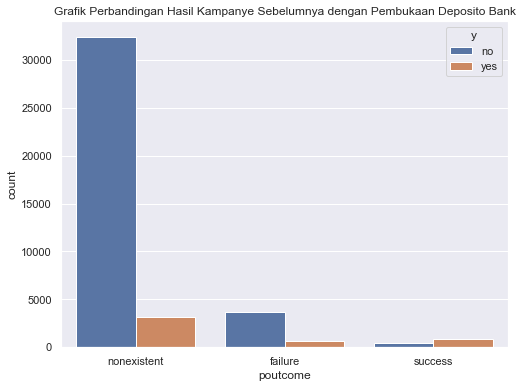

In [99]:
# Visualisasi data Analisis Multivariate antara poutcome dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'poutcome', data = df , hue = 'y')
plt.title('Grafik Perbandingan Hasil Kampanye Sebelumnya dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : CLient yang membuka deposito didominasi oleh kelompok tidak ada hasil dari kampanye sebelumnya

In [100]:
# Analisis Multivariate antara emp.var.rate dan y
(pd.crosstab(index = df['emp.var.rate'], columns = df['y'], normalize = 'all')*100).round(2)

y,no,yes
emp.var.rate,,
-3.4,1.50,1.10
-3.0,0.20,0.21
-2.9,2.60,1.44
-1.8,18.75,3.55
-1.7,0.90,0.98
-1.1,0.81,0.73
-0.2,0.02,0.00
-0.1,8.38,0.56
1.1,18.27,0.58


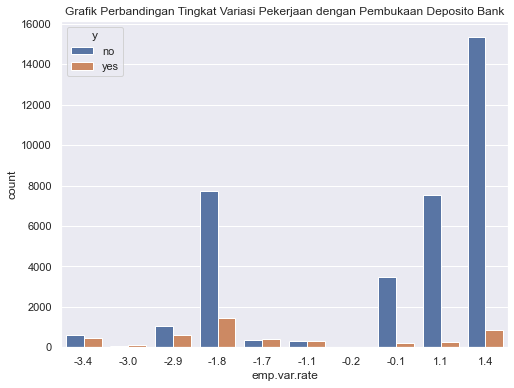

In [101]:
# Visualisasi data Analisis Multivariate antara emp.var.rate dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'emp.var.rate', data = df , hue = 'y')
plt.title('Grafik Perbandingan Tingkat Variasi Pekerjaan dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Client yang membuka deposito didominasi oleh kelompok dengan tingkat variasi pekerjaan sebesar -1.8

In [102]:
# Analisis Multivariate antara cons.price.idx dan y
(pd.crosstab(index = df['cons.price.idx'], columns = df['y'], normalize = 'all')*100).round(2)

y,no,yes
cons.price.idx,,
92.201,1.23,0.64
92.379,0.39,0.26
92.431,0.65,0.44
92.469,0.27,0.16
92.649,0.46,0.41
92.713,0.20,0.21
92.756,0.02,0.00
92.843,0.38,0.31
92.893,12.79,1.27


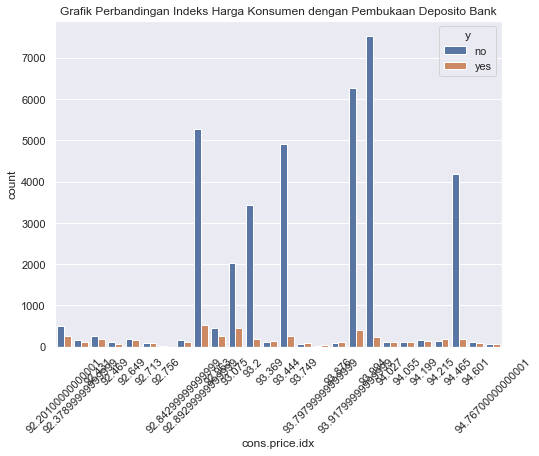

In [103]:
# Visualisasi data Analisis Multivariate antara cons.price.idx dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.price.idx', data = df , hue = 'y')
plt.title('Grafik Perbandingan Indeks Harga Konsumen dengan Pembukaan Deposito Bank')
plt.xticks(rotation=45)
plt.show()

Insight : Client yang membuka deposito didominasi kelompok Indeks Harga Konsumen sebesar 92.893

In [104]:
# Analisis Multivariate antara cons.conf.idx dan y
(pd.crosstab(index = df['cons.conf.idx'], columns = df['y'], normalize = 'all')*100).round(2)

y,no,yes
cons.conf.idx,,
-50.8,0.17,0.14
-50.0,0.38,0.31
-49.5,0.27,0.23
-47.1,4.89,1.07
-46.2,12.79,1.27
-45.9,0.02,0.00
-42.7,15.24,0.99
-42.0,8.32,0.46
-41.8,10.16,0.46


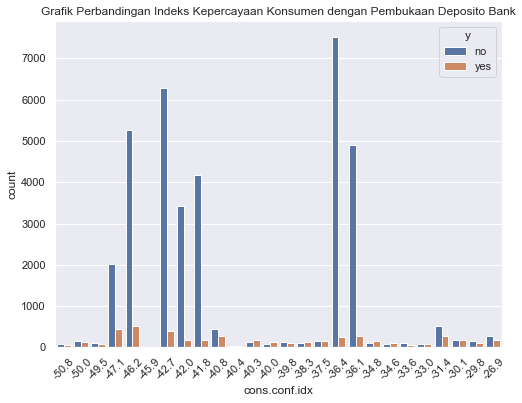

In [105]:
# Visualisasi data Analisis Multivariate antara cons.conf.idx dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'cons.conf.idx', data = df , hue = 'y')
plt.title('Grafik Perbandingan Indeks Kepercayaan Konsumen dengan Pembukaan Deposito Bank')
plt.xticks(rotation=45)
plt.show()

Insight : Client yang membuka deposito didominasi oleh kelompok dengan indeks kepercayaan konsumen sebesar -46.2

In [106]:
# Pengelompokan kategori index euribor
eur_bin = [0, 1, 2, 3, 4, df['pdays'].max()] ## Membuat Kelompok Euribor
labels_eur = ['0 - 1', '1 - 2', '2 - 3', '3 - 4', '>4'] ## Label untuk Kelompok Euribor
df['eur_bin'] = pd.cut(df['euribor3m'], bins=eur_bin, labels=labels_eur)

In [107]:
# Analisis Multivariate antara euribor3m dan y
(pd.crosstab(index = df['eur_bin'], columns = df['y'], normalize = 'all')*100).round(2)

y,no,yes
eur_bin,,
0 - 1,5.15,4.34
1 - 2,19.61,3.68
3 - 4,0.03,0.00
>4,63.95,3.25


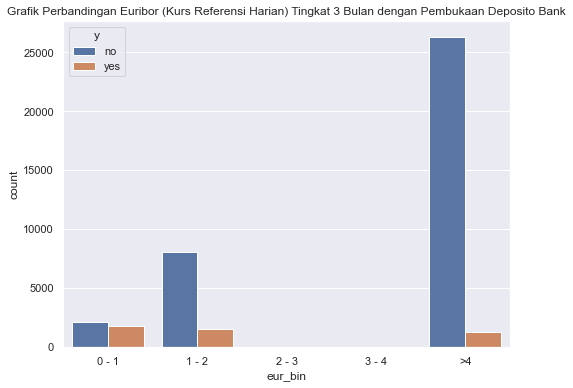

In [108]:
# Visualisasi data Analisis Multivariate antara euribor3m dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'eur_bin', data = df , hue = 'y')
plt.title('Grafik Perbandingan Euribor (Kurs Referensi Harian) Tingkat 3 Bulan dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Client yang melakukan pembukaan deposito didominasi oleh kelompok euribor sebesar 0 - 1

In [109]:
# Analisis Multivariate antara nr.employed dan y
(pd.crosstab(index = df['nr.employed'], columns = df['y'], normalize = 'all')*100).round(2)

y,no,yes
nr.employed,,
4963.6,0.81,0.73
4991.6,0.90,0.98
5008.7,0.68,0.90
5017.5,1.50,1.10
5023.5,0.20,0.21
5076.2,2.60,1.44
5099.1,18.07,2.65
5176.3,0.02,0.00
5191.0,18.27,0.58


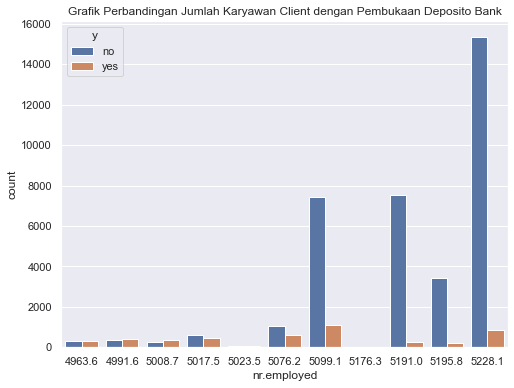

In [110]:
# Visualisasi data Analisis Multivariate antara nr.employed dan y
plt.figure(figsize = (8,6))
sns.countplot(x = 'nr.employed', data = df , hue = 'y')
plt.title('Grafik Perbandingan Jumlah Karyawan Client dengan Pembukaan Deposito Bank')
# plt.xticks(rotation=45)
plt.show()

Insight : Client yang membuka deposito didominasi oleh kelompok dengan jumlah karyawan sebanyak 5228 karyawan